<center><h1> Self driving car</h1></center>

## Problem statement

We are here building a minimal version of self driving car. Here, we have a front camera view. This will transfer input to the computer. Then Deep Learning algorithm in computer predicts the steering angle to avoid all sorts of collisions. Predicting steering angle can be thought of as a regression problem. We will feed images to Convolutional Neural Network and the label will be the steering angle in that image. Model will learn the steering angle from the as per the turns in the image and will finally predicts steering angle for unknown images.

## Dataset
Refer this: https://github.com/SullyChen/Autopilot-TensorFlow

There are total 45406 images in the dataset along with their steering angles. We will split the dataset into train and test in a ratio of 70:30 sequentially.

In [ ]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [1]:
# import packages
import scipy.misc
import cv2
import imageio
import pandas as pd
import cv2
from tensorflow.core.protobuf import saver_pb2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Loading data

In [14]:
drivind_data_path = r"D:/AAIC/Self Driving Car/Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/"

In [2]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open(driving_data_path+"data.txt") as f:
    for line in f:
        xs.append(driving_data_path + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

train_data_size = 0.7
train_xs = xs[:int(len(xs) * train_data_size)]
train_ys = ys[:int(len(xs) * train_data_size)]

val_xs = xs[-int(len(xs) * (1 - train_data_size)):]
val_ys = ys[-int(len(xs) * (1 - train_data_size)):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)


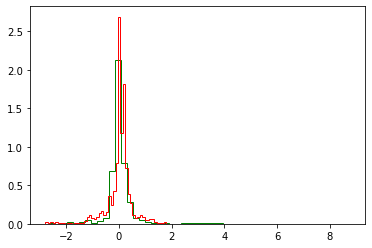

In [6]:
import numpy

# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.hist(train_ys, bins=50, density = True,color='green', histtype ='step');
plt.hist(val_ys, bins=50, density = True,color='red', histtype ='step');
plt.show()

In [7]:
# utility functions

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(cv2.resize(imageio.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], (200, 66)) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(cv2.resize(imageio.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], (200, 66)) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

## Model

In [19]:
# model utility functions

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')


In [9]:
# model architecture
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.identity(tf.matmul(h_fc4_drop, W_fc5) + b_fc5) #scale the linear output


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<img src = "Model_Architecture.png">

## Model training

In [ ]:
LOGDIR = './save'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100
lst_epochs = []
lst_steps = []
lst_losses = []
#epoch_loss = []
# train over the dataset about 30 times
for epoch in range(epochs):
    for i in range(int(driving_data.num_images/batch_size)):
        xs, ys = driving_data.LoadTrainBatch(batch_size)
        train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})
        if i % 10 == 0:
            xs, ys = driving_data.LoadValBatch(batch_size)
            loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
            print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))
            lst_epochs.append(epoch)
            lst_steps.append(epoch * batch_size + i)
            lst_losses.append(loss_value)
        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

        if i % batch_size == 0:
            if not os.path.exists(LOGDIR):
                os.makedirs(LOGDIR)
            checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
        print("Model saved in file: %s" % filename)


In [ ]:
# save model output
dict = {'Epoch':lst_epochs,'Step':lst_steps,'Loss':lst_losses}
df = pd.DataFrame(dict)
df.to_csv("Output.csv",index=False)


In [12]:
data = pd.read_csv("Output.csv")

In [13]:
data

,Epoch,Step,Loss
0,0,0,6.288713
1,0,10,6.171926
2,0,20,6.123745
3,0,30,6.112089
4,0,40,6.343522
...,...,...,...
1375,29,3310,0.182739
1376,29,3320,0.849366
1377,29,3330,0.264896
1378,29,3340,0.563566


## Model testing

In [20]:
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0


#read data.txt
xs = []
ys = []
with open(drivind_data_path+"data.txt") as f:
    for line in f:
        xs.append(drivind_data_path + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*train_data_size)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = imageio.imread(drivind_data_path + str(i) + ".jpg")
    image = cv2.resize(full_image[-150:], (200, 66)) / 255.0
    degrees = y.eval(feed_dict={x: [image], keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


INFO:tensorflow:Restoring parameters from save/model.ckpt
Starting frameofvideo:31785
Steering angle: -1.809407397699469 (pred)	-28.34 (actual)
Steering angle: -1.4587672569389936 (pred)	-28.840000000000003 (actual)
Steering angle: -0.6214949208353274 (pred)	-29.75 (actual)
Steering angle: -0.28267058045215115 (pred)	-31.06 (actual)
Steering angle: -0.9685218915248659 (pred)	-32.27 (actual)
Steering angle: 0.011117626978076693 (pred)	-33.48 (actual)
Steering angle: 1.0189487512802469 (pred)	-34.39 (actual)
Steering angle: 2.891273717179758 (pred)	-35.599999999999994 (actual)
Steering angle: 3.0659252827949803 (pred)	-36.5 (actual)
Steering angle: 5.004526562418887 (pred)	-37.61 (actual)
Steering angle: 5.158972080591684 (pred)	-38.62 (actual)
Steering angle: 6.593971346436091 (pred)	-39.63 (actual)
Steering angle: 7.278358008818661 (pred)	-39.93000000000001 (actual)
Steering angle: 6.9975211207152475 (pred)	-40.03000000000001 (actual)
Steering angle: 6.549335206436412 (pred)	-40.030000